# Cloning the Repository (pc-gym)

In [1]:
!dir pc-gym

 Volume in drive C is IC-5CG3421JZ2
 Volume Serial Number is 6421-EDCF

 Directory of c:\Users\mfb22\Documents\GitHub\pcgym\pc-gym_paper\disturbance_showcase\EVALUATE



File Not Found


In [2]:
# %cd pc-gym

# Importing Libraries

In [3]:
# %cd src

In [4]:
# %cd pcgym

In [5]:
%cd C:/Users/Usuario/Desktop/imperial_projects/VSCode/pcgym2/pc-gym

[WinError 3] The system cannot find the path specified: 'C:/Users/Usuario/Desktop/imperial_projects/VSCode/pcgym2/pc-gym'
c:\Users\mfb22\Documents\GitHub\pcgym\pc-gym_paper\disturbance_showcase\EVALUATE


In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Enable LaTeX rendering
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'

In [2]:
from dataclasses import dataclass
import numpy as np
import torch
import matplotlib.pyplot as plt
import gymnasium as gym
import torch.nn.functional as F
import copy
from stable_baselines3 import PPO,SAC,DDPG,TD3
import pcgym
from pcgym import make_env
import jax.numpy as jnp
#Global params
T = 26
nsteps = 60
# Global seed for reproducibility
seed = 1990

# Saving and loading

Saving and loading stable-baselines models is straightforward: you can directly call `.save()` and `.load()` on the models.

In [8]:
import os
# Create base save dir for DDPG
save_dir_ddpg_base = "../Train/base/ddpg"
os.makedirs(save_dir_ddpg_base, exist_ok=True)

In [9]:
# Create base save dir for TD3
save_dir_td3_base = "C:/Users/Usuario/Desktop/imperial_projects/VSCode/pcgym2/train/base/td3"
os.makedirs(save_dir_td3_base, exist_ok=True)

PermissionError: [WinError 5] Access is denied: 'C:/Users/Usuario'

In [10]:
# Create base save dir for SAC
save_dir_sac_base = "C:/Users/Usuario/Desktop/imperial_projects/VSCode/pcgym2/train/base/sac"
os.makedirs(save_dir_sac_base, exist_ok=True)

In [11]:
# Create base save dir for PPO
save_dir_ppo_base = "C:/Users/Usuario/Desktop/imperial_projects/VSCode/pcgym2/train/base/ppo"
os.makedirs(save_dir_ppo_base, exist_ok=True)

In [12]:
import os
# Create save dir for testing metrics
save_dir_test_base = "C:/Users/Usuario/Desktop/imperial_projects/VSCode/pcgym2/evaluate/pcgym_paper"
os.makedirs(save_dir_test_base, exist_ok=True)

# Monitoring experiments with W&B

In [13]:
!wandb login 84af17cc9914cf1736f3a8e2733a2f361e4750bb

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Usuario\.netrc


# 1.1 Reactor Case Study

In [3]:
# @title Function to log the performance data
def log_performance(performance, test_label, file_path):
    with open(file_path, "a") as file:
        file.write(f"{test_label}: \n")
        file.write(f"scalarised_performance: {performance}\n\n")

file_path = f"{save_dir_test_base}/lcb_metric_safe.txt"

NameError: name 'save_dir_test_base' is not defined

### Environment Definition

In [162]:
import torch as th
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
import os
import sys
from stable_baselines3 import PPO, SAC, DDPG
import matplotlib.pyplot as plt
from matplotlib import rcParams

##################################################################################
# Environment Definition
##################################################################################

# Enter required setpoints for each state. Enter None for states without setpoints.
SP = {
    # 'T': [324.475443431599 for _ in range(5)] + [340.0 for _ in range(nsteps - 5)],
    'T': [325.0 for _ in range(nsteps)]
}

# Continuous box action space
action_space = {
    'low': np.array([295]),
    'high': np.array([302])
}

# Continuous box observation space ([CA, T, CA_Setpoint, T_Setpoint])
observation_space = {
    'low': np.array([0.0, 300, 300]),
    'high': np.array([1, 450, 400])
}

r_scale = {
    'T': 1e-6  # Reward scale for each state
}

# Define disturbance bounds
disturbance_bounds = {
    'low': np.array([330]),
    'high': np.array([370])
}

# Seed everything for reproducibility
def set_global_seeds(seed):
    np.random.seed(seed)
    th.manual_seed(seed)
    if th.cuda.is_available():
        th.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# Function to create random disturbances
def create_random_disturbances(seed, nsteps, low=345, high=355):
    # Set the global seed for reproducibility
    set_global_seeds(seed)
    value = np.random.uniform(low, high, 1)[0]  # Generate a single random disturbance value within the specified range
    disturbances = {'Ti': [350] * (nsteps // 3) + [value] * (nsteps // 3) + [350] * (nsteps // 3)}  # Repeat each disturbance value for nsteps/3 times
    return disturbances

# Environment parameters template
env_params_template = {
    'Nx': 2,
    'N': 60,
    'tsim': 26,
    'Nu': 1,
    'SP': SP,
    'o_space': observation_space,
    'a_space': action_space,
    'x0': np.array([0.87725294608097, 324.475443431599, 324.475443431599]),
    'model': 'cstr',
    'r_scale': r_scale,
    'normalise_a': True,
    'normalise_o': True,
    'noise': True,
    'integration_method': 'casadi',
    'noise_percentage': 0.001,
    'disturbance_bounds': disturbance_bounds,
}

# Function to create an environment
def create_env(env_params):
    set_global_seeds(seed)
    env = make_env(env_params)
    return env

# Function to create an environment with specific disturbances
def create_eval_env_with_disturbances(seed, disturbances):
    set_global_seeds(seed)
    env_params = env_params_template.copy()
    env_params.update({
        'disturbances': disturbances,
        'disturbance_bounds': disturbance_space,
        'N': 60,
    })
    return create_env(env_params)

# Disturbance bounds for 'Ti'
disturbance_space = {
    'low': np.array([330]),
    'high': np.array([370])
}

# Load the best trained RL policies
# best_model_ppo = "../TRAIN/max/ppo/best_model.zip"
best_model_ppo = "../TRAIN/max/ppo/best_model"
PPO_cstr_dist = PPO.load(best_model_ppo)
best_model_sac = "../TRAIN/max/sac/best_model"
SAC_cstr_dist = SAC.load(best_model_sac)
best_model_ddpg = "../TRAIN/max/ddpg/best_model"
DDPG_cstr_dist = DDPG.load(best_model_ddpg)


# Number of disturbances to evaluate
num_disturbances = 10

# Generate the first 10 disturbances using different seeds
disturbances_list = []
for i in range(num_disturbances):
    disturbance = create_random_disturbances(seed + i, nsteps)
    disturbances_list.append(disturbance)
    
# Create a list to store evaluation results for each disturbance
evaluation_results = []

# Number of rollouts for evaluation
rollout_number = 20

# MPC Parameters optimized for 1st disturbance
MPC_params = {
    'N': 12,  # Horizon length
    # 'R': np.diag([2.419078e-03] * env_params_template['Nu']),  # R as a diagonal matrix with the same value on the diagonal
    # 'Q': np.eye(env_params_template['Nx']) * 3.382159e-01  # Q as an identity matrix (optional)
}

# Policies to evaluate
policies = ['SAC', 'DDPG']
disturbances_list[0] = {'Ti': [350] * (nsteps // 3) + [357.5] * (nsteps // 3) + [350] * (nsteps // 3)}
# Loop over the first 10 disturbances and evaluate the policies
# for idx, disturbance in enumerate(disturbances_list):
# print(f"Evaluating disturbance {idx + 1}/{num_disturbances}: {disturbance}")

# Create environment for the current disturbance
env_with_disturbance = create_eval_env_with_disturbances(seed , disturbances_list[0])

# Visualise policies with the oracle for the current disturbance
evaluator, data = env_with_disturbance.get_rollouts(
    {'SAC': SAC_cstr_dist, 'PPO': PPO_cstr_dist, 'DDPG': DDPG_cstr_dist}, 
    reps=rollout_number, 
    oracle=True, 
    MPC_params=MPC_params, 
)

# Save the evaluation results for this disturbance
evaluation_results.append(data)

# After evaluation, calculate aggregate statistics such as mean or median rewards
mean_rewards = {policy: np.mean([result[policy]["r"].sum(axis=1).flatten() for result in evaluation_results], axis=0) 
                for policy in policies}

# Print the mean rewards for each policy
for policy in policies:
    print(f"Mean reward for {policy} over the first {num_disturbances} disturbances: {np.mean(mean_rewards[policy])}")


c:\Users\mfb22\AppData\Local\anaconda3\envs\pcgym_test\Lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(


Mean reward for SAC over the first 10 disturbances: -0.0009944975537464985
Mean reward for DDPG over the first 10 disturbances: -0.018836796509102992


In [165]:
o_r = np.median(evaluation_results[0]['oracle']["r"].sum(axis=1).flatten())
for i, policy in enumerate(policies):
    print(f'{policy} optimality gap: {((o_r - np.median(evaluation_results[0][policy]["r"].sum(axis=1).flatten())))}')

SAC optimality gap: 0.0009945160573906454
DDPG optimality gap: 0.018856007650277073


# 2 Testing

In [16]:
# @title Save data as a pickle file
import pickle

with open(f"./data.pkl", "wb") as file:
    pickle.dump(data, file)

print(f"data has been saved to {save_dir_test_base}/data.pkl")

data has been saved to C:/Users/Usuario/Desktop/imperial_projects/VSCode/pcgym2/evaluate/pcgym_paper/data.pkl


In [24]:
# Visualise policies with the oracle
oracle_r = np.median(data['oracle']["r"].sum(axis=1).flatten())
policies = ['SAC', 'PPO', 'DDPG',]

In [6]:
for i, policy in enumerate(policies):
    print(f'{policy} optimality gap: {((oracle_r - np.median(data[policy]["r"].sum(axis=1).flatten()))/oracle_r)}')

SAC optimality gap: -9.350132585867119
PPO optimality gap: -7.805386495312701
DDPG optimality gap: -7.717379352811892


In [158]:
def paper_plot(data, disturbances):
    # Set up LaTeX rendering
    rcParams['text.usetex'] = True
    rcParams['font.family'] = 'serif'
    rcParams['axes.labelsize'] = 10
    rcParams['xtick.labelsize'] = 10
    rcParams['ytick.labelsize'] = 10
    rcParams['legend.fontsize'] = 10

    # Generate t with 101 points to match data dimensions
    t = np.linspace(0, 25, 60)

    # A4 width in inches
    a4_width_inches = 8.27
    
    # Calculate height to maintain aspect ratio
    height = a4_width_inches * 0.4  # Adjust this factor as needed
    
    # Create 2 rows and 3 columns (with the middle plot in the second row filled)
    fig, axs = plt.subplots(1, 3, figsize=(a4_width_inches, height * 2))
    plt.subplots_adjust(wspace=0.6, hspace=0.3, top=0.85, bottom=0.15, left=0.08, right=0.98)

    policies = ['oracle', 'SAC',  'DDPG']
    cols = ['tab:orange', 'tab:red',  'tab:green', 'tab:purple']
    labels = ['Oracle', 'SAC', 'DDPG']

    # Create lines for the legend (use the first plot)
    lines = []
    for i, policy in enumerate(policies):
        line, = axs[0].plot([], [], color=cols[i], label=labels[i])
        lines.append(line)
    ref_line, = axs[0].plot([], [], color='black', linestyle='--',  label='Reference')
    lines.append(ref_line)
    dist_line, = axs[0].plot([], [], color='tab:grey',linestyle = '-.',label='Disturbance ($T_i$)')
    lines.append(dist_line)

    # Create legend above the plots
    fig.legend(handles=lines, loc='upper center', bbox_to_anchor=(0.5, 0.7),
               ncol=6, frameon=False, columnspacing=1)

    y_labels = [r'$T$ / $T_i$ [K]', r'$T_c$ [K]', 'Cumulative Reward']

    # First row: temperature and control variables, and histogram
    for idx in range(3):
        ax = axs[idx]  # Access the first row of subplots
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_axisbelow(True)
        
        if idx == 0:
            for i, policy in enumerate(policies):
                linestyle = '--' if policy == 'oracle' else '-'
                ax.plot(t, np.median(data[policy]['x'][1, :, :], axis=1), color=cols[i], linewidth=2 if policy == 'oracle' else 1.25, linestyle=linestyle)
                ax.fill_between(t, np.max(data[policy]['x'][1, :, :], axis=1), 
                                np.min(data[policy]['x'][1, :, :], axis=1), 
                                alpha=0.2, linewidth=0, color=cols[i])
            if 'SAC' in data:
                ax.step(t, data['SAC']['x'][2, :, 0], color='black', linestyle='--')
            
            ax.set_ylabel(y_labels[idx])
            ax.set_xlabel(r'Time [min]')
            ax.set_xlim(0, 25)

            # Create a second y-axis for disturbances
            # ax2 = ax.twinx()
            ax.step(t, disturbances, color='tab:grey', linewidth=1.5, alpha=0.7, linestyle='-.', zorder=0)
            # ax.set_ylabel(r'', color='tab:purple')
            # ax.tick_params(axis='y', labelcolor='tab:purple')

        if idx == 1:
            for i, policy in enumerate(policies):
                ax.step(t, np.median(data[policy]['u'][0, :, :], axis=1), color=cols[i], where='post', linewidth=1.25)
                ax.fill_between(t, np.max(data[policy]['u'][0, :, :], axis=1), 
                                np.min(data[policy]['u'][0, :, :], axis=1),
                                step="post", alpha=0.2, linewidth=0, color=cols[i])
            ax.set_ylabel(y_labels[idx])
            ax.set_xlabel(r'Time [min]')
            ax.set_xlim(0, 25)

        if idx == 2:
            # Get all rewards excluding Oracle for the histogram
            all_rewards = np.concatenate([data[policy]["r"].sum(axis=1).flatten() for policy in policies if policy != 'oracle'])
            min_reward, max_reward = np.min(all_rewards), np.max(all_rewards)
            print(np.min(all_rewards), np.max(all_rewards))
            bins = np.linspace(min_reward-0.00025, max_reward+0.00025, 50)
            # bins = np.linspace(min_reward, max_reward, 10)
            # Plot histograms for SAC, PPO, DDPG (exclude Oracle)
            for i, policy in enumerate(policies):
                if policy != 'oracle':  # Skip plotting Oracle as a bar
                    print(policy)
                    ax.hist(
                        data[policy]["r"].sum(axis=1).flatten(),
                        bins=bins,
                        color=cols[i],
                        alpha=0.5,
                        label=labels[i],
                        edgecolor='None',
                    )

            # Add the vertical line for Oracle
            ax.axvline(x=np.median(data['oracle']["r"].sum(axis=1)), color=cols[0], linestyle='--', linewidth=2, label='Oracle')
            ax.set_ylabel('Frequency')
            ax.set_xlabel('Cumulative Reward')
            # ax.set_xlim( max_reward,min_reward)
  

    # Adjust the layout and spacing for a better fit
    for ax in axs.flatten():
        if ax.get_subplotspec().get_geometry() != (2, 3, 4):  # Skip the removed subplot
            ax.set_box_aspect(1)

    plt.savefig('cstr_dist_with_Ti_combined_03_10.pdf', bbox_inches='tight', pad_inches=0.1)
    plt.show()

-0.00042610775557978115 -0.0003706265787435835
SAC
DDPG


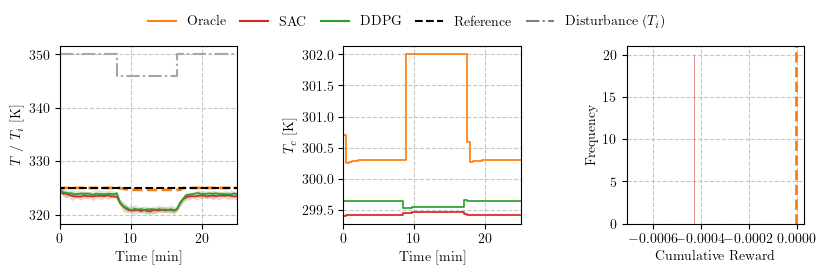

In [ ]:
# Get the disturbances from the disturbances_list
# Assuming you want to visualize the disturbances for the 1st evaluation
eval = 3

disturbances = disturbances_list[eval]['Ti']
# print(evaluation_results[0]['SAC']['r'].sum(axis=1).flatten())
paper_plot(evaluation_results[eval], disturbances)  # Plot the data from the 1st disturbance

-0.018980304965681007 -0.0009939966883497906
SAC
DDPG


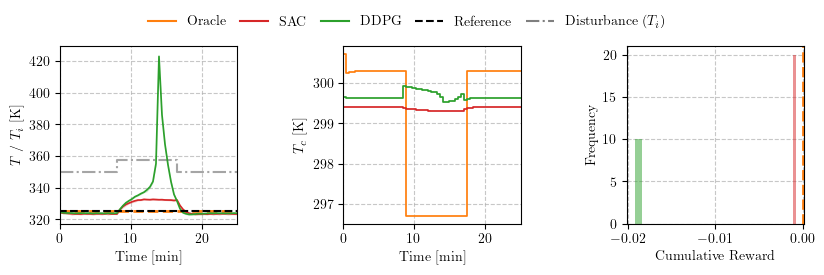

array([-0.00099413, -0.00099472, -0.00099454, -0.00099467, -0.00099428,
       -0.00099419, -0.00099444, -0.00099449, -0.00099464, -0.0009947 ,
       -0.00099469, -0.00099441, -0.00099489, -0.00099497, -0.00099444,
       -0.00099434, -0.00099454, -0.000994  , -0.00099461, -0.00099425])

In [163]:
# Get the disturbances from the disturbances_list
# Assuming you want to visualize the disturbances for the 10th evaluation
disturbances = disturbances_list[0]['Ti']

paper_plot(evaluation_results[0],disturbances)  # Plot the data from the 10th disturbance
evaluation_results[0]['SAC']['r'].sum(axis=1).flatten() 

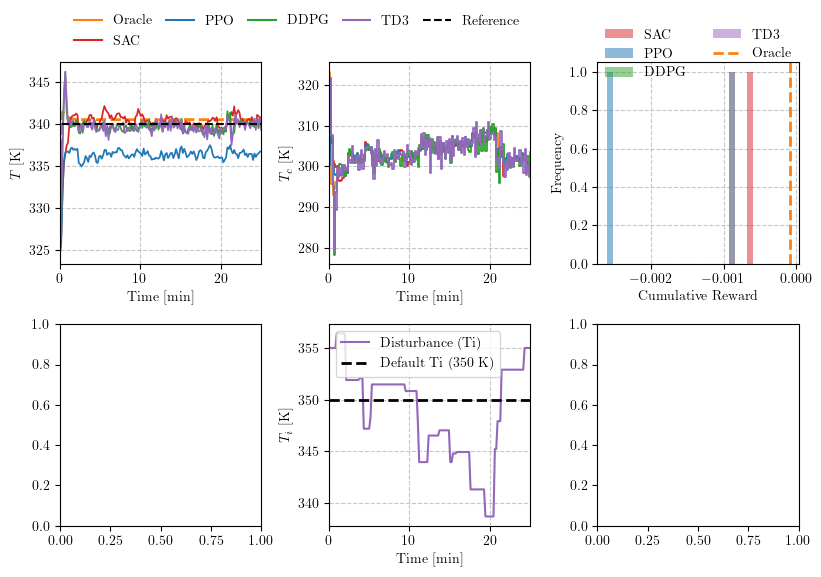

In [23]:
# Aggregating the data for each policy, except 'oracle'
aggregated_data = {
    policy: {
        'x': np.mean([result[policy]['x'] for result in evaluation_results], axis=0),
        'u': np.mean([result[policy]['u'] for result in evaluation_results], axis=0),
        'r': np.mean([result[policy]['r'] for result in evaluation_results], axis=0),
    }
    for policy in ['SAC', 'PPO', 'DDPG', 'TD3']  # Aggregating for these policies
}

# Compute the mean reward for 'oracle' across all disturbances
oracle_r = np.mean([result['oracle']["r"].sum(axis=1).flatten() for result in evaluation_results], axis=0)

# Add the oracle data manually to the aggregated data
aggregated_data['oracle'] = {
    'x': np.mean([result['oracle']['x'] for result in evaluation_results], axis=0),
    'u': np.mean([result['oracle']['u'] for result in evaluation_results], axis=0),
    'r': np.tile(oracle_r, (evaluation_results[0]['oracle']['r'].shape[0], 1))  # Replicate the oracle reward across time steps
}

# Compute the mean disturbance (Ti) across all 10 disturbance scenarios
mean_disturbance = np.mean([disturbance['Ti'] for disturbance in disturbances_list], axis=0)

# Now call the paper_plot function with the aggregated data and mean disturbance
paper_plot(aggregated_data, mean_disturbance)


In [24]:
# @title Log Reproducibility metric
from pcgym.evaluation_metrics import reproducibility_metric

# env_params.update({
#     'N': 100,
# })

policy_measure = reproducibility_metric(dispersion='mad', performance='mean', scalarised_weight=-1000)
scalarised_performance = policy_measure.evaluate(evaluator, component="r",) #component=None)

scalarised_performance

test_label = "1st: Disturbance test"
log_performance(scalarised_performance, test_label, file_path)

In [25]:
# Set a different seed for the new disturbances
new_seed = 12345  # Replace this with your desired seed

# Generate new disturbances using the different seed
new_disturbances_list = []
for i in range(num_disturbances):
    new_disturbance = create_random_disturbances(new_seed + i, nsteps)
    new_disturbances_list.append(new_disturbance)

# Create a list to store evaluation results for the new disturbances
new_evaluation_results = []

# Loop over the new disturbances and evaluate the policies
for idx, new_disturbance in enumerate(new_disturbances_list):
    print(f"Evaluating new disturbance {idx + 1}/{num_disturbances}: {new_disturbance}")
    
    # Create environment for the current disturbance with the new seed
    env_with_new_disturbance = create_eval_env_with_disturbances(new_seed + idx, new_disturbance)
    
    # Visualise policies with the oracle for the current disturbance
    evaluator, new_data = env_with_new_disturbance.get_rollouts(
        {'SAC': SAC_cstr_dist, 'PPO': PPO_cstr_dist, 'DDPG': DDPG_cstr_dist, 'TD3': TD3_cstr_dist}, 
        reps=rollout_number, 
        oracle=True, 
        MPC_params=MPC_params
    )
    
    # Save the evaluation results for this disturbance
    new_evaluation_results.append(new_data)

# After evaluation, calculate aggregate statistics such as mean or median rewards
new_mean_rewards = {policy: np.mean([result[policy]["r"].sum(axis=1).flatten() for result in new_evaluation_results], axis=0) 
                    for policy in policies}

# Print the mean rewards for each policy with the new disturbances
for policy in policies:
    print(f"Mean reward for {policy} over the new set of disturbances: {np.mean(new_mean_rewards[policy])}")

Evaluating new disturbance 1/10: {'Ti': array([380.0731265 , 380.0731265 , 380.0731265 , 380.0731265 ,
       380.0731265 , 380.0731265 , 380.0731265 , 380.0731265 ,
       380.0731265 , 380.0731265 , 380.0731265 , 380.0731265 ,
       380.0731265 , 380.0731265 , 380.0731265 , 380.0731265 ,
       380.0731265 , 380.0731265 , 380.0731265 , 380.0731265 ,
       380.0731265 , 380.0731265 , 380.0731265 , 380.0731265 ,
       380.0731265 , 380.0731265 , 380.0731265 , 380.0731265 ,
       380.0731265 , 380.0731265 , 380.0731265 , 380.0731265 ,
       380.0731265 , 380.0731265 , 380.0731265 , 380.0731265 ,
       380.0731265 , 380.0731265 , 380.0731265 , 380.0731265 ,
       380.0731265 , 380.0731265 , 380.0731265 , 337.14628882,
       337.14628882, 337.14628882, 337.14628882, 337.14628882,
       337.14628882, 337.14628882, 337.14628882, 337.14628882,
       337.14628882, 337.14628882, 337.14628882, 337.14628882,
       337.14628882, 337.14628882, 337.14628882, 337.14628882,
       337.1462

In [26]:
# Save evaluation results for the new disturbances
import pickle

with open(f"{save_dir_test_base}/new_data.pkl", "wb") as file:
    pickle.dump(evaluation_results, file)

print(f"Data has been saved to {save_dir_test_base}/new_data.pkl")

Data has been saved to C:/Users/Usuario/Desktop/imperial_projects/VSCode/pcgym2/evaluate/pcgym_paper/new_data.pkl


In [27]:
# Calculate the mean reward for the 'oracle'
oracle_r = np.mean([result['oracle']["r"].sum(axis=1).flatten() for result in evaluation_results], axis=0)

# List of policies to evaluate
policies = ['SAC', 'PPO', 'DDPG', 'TD3']

# Calculate the optimality gap for each policy
for i, policy in enumerate(policies):
    policy_mean_reward = np.mean([result[policy]["r"].sum(axis=1).flatten() for result in evaluation_results], axis=0)
    optimality_gap = oracle_r - policy_mean_reward
    print(f'{policy} optimality gap: {optimality_gap}')

SAC optimality gap: [0.00050467]
PPO optimality gap: [0.00252762]
DDPG optimality gap: [0.00078913]
TD3 optimality gap: [0.00076511]


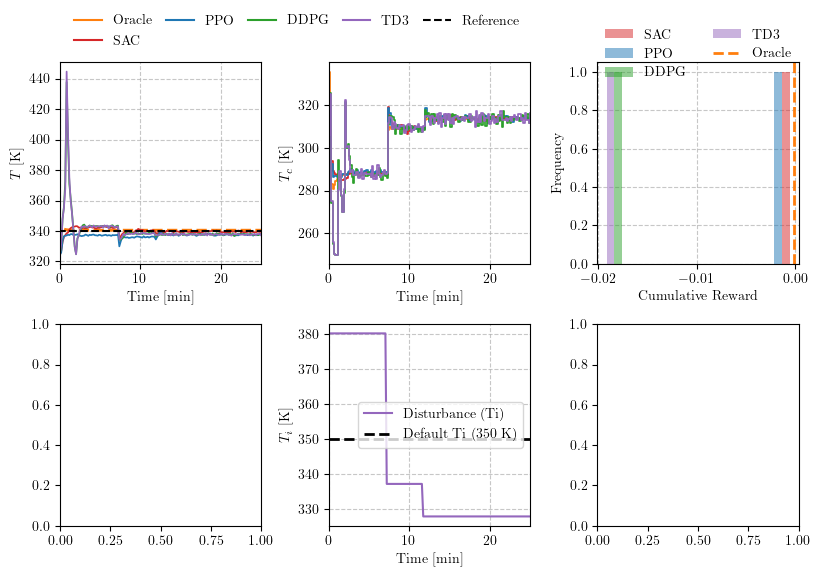

In [31]:
# Get the disturbances from the **new** disturbances_list for the 1st evaluation
disturbances = new_disturbances_list[0]['Ti']

# Plot the data for the 1st disturbance
paper_plot(new_evaluation_results[0], disturbances)

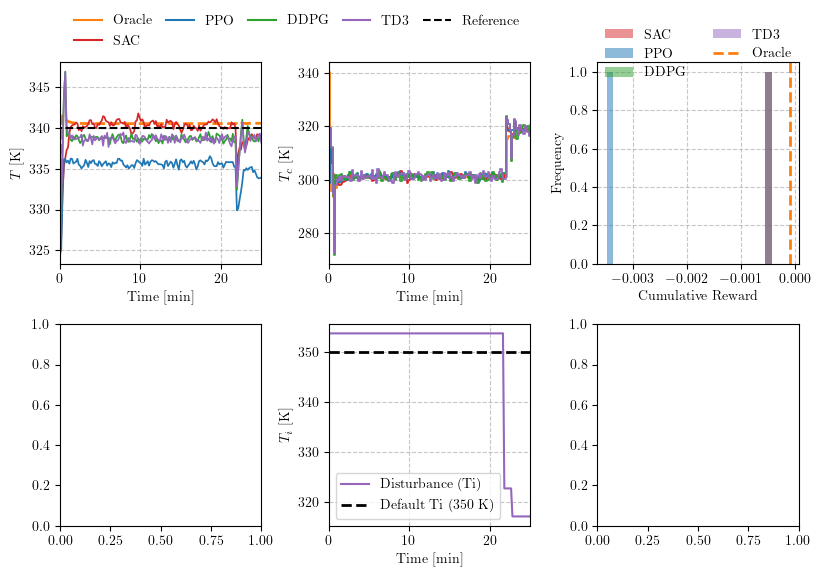

In [33]:
# Get the disturbances from the **new** disturbances_list for the 10th evaluation
disturbances = new_disturbances_list[9]['Ti']

# Plot the data for the 10th disturbance
paper_plot(new_evaluation_results[9], disturbances)

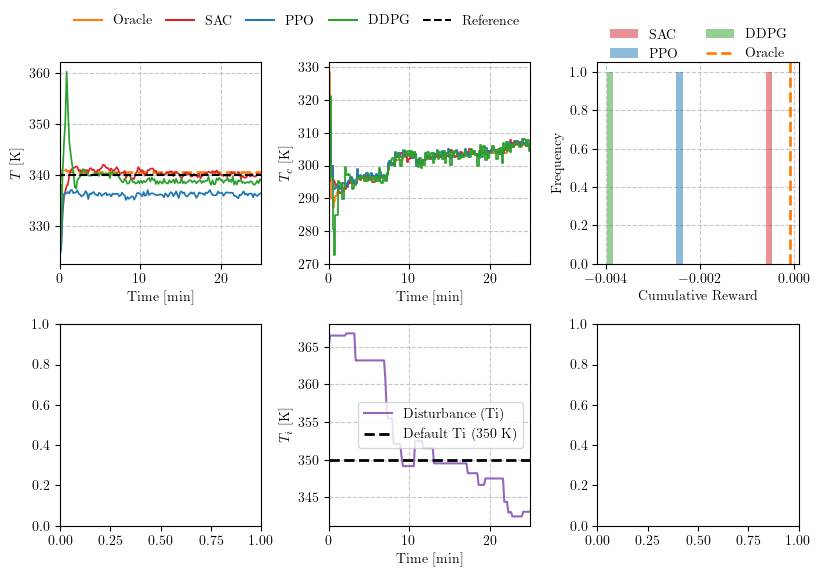

In [38]:
# Aggregating the data for each policy, except 'oracle', for the new disturbances
aggregated_data_new = {
    policy: {
        'x': np.mean([result[policy]['x'] for result in new_evaluation_results], axis=0),
        'u': np.mean([result[policy]['u'] for result in new_evaluation_results], axis=0),
        'r': np.mean([result[policy]['r'] for result in new_evaluation_results], axis=0),
    }
    for policy in ['SAC', 'PPO', 'DDPG', 'TD3']  # Aggregating for these policies
}

# Compute the mean reward for 'oracle' across all new disturbances
oracle_r_new = np.mean([result['oracle']["r"].sum(axis=1).flatten() for result in new_evaluation_results], axis=0)

# Add the oracle data manually to the aggregated data
aggregated_data_new['oracle'] = {
    'x': np.mean([result['oracle']['x'] for result in new_evaluation_results], axis=0),
    'u': np.mean([result['oracle']['u'] for result in new_evaluation_results], axis=0),
    'r': np.tile(oracle_r_new, (new_evaluation_results[0]['oracle']['r'].shape[0], 1))  # Replicate the oracle reward across time steps
}

# Compute the mean disturbance (Ti) across all new disturbance scenarios
mean_disturbance_new = np.mean([disturbance['Ti'] for disturbance in new_disturbances_list], axis=0)

# Now call the paper_plot function with the aggregated data and mean disturbance
paper_plot(aggregated_data_new, mean_disturbance_new)


In [39]:
# @title Function to log the performance data with a dynamic file name
def log_performance(performance, test_label, file_path):
    with open(file_path, "a") as file:
        file.write(f"{test_label}: \n")
        file.write(f"scalarised_performance: {performance}\n\n")

# @title Function to create a dynamic file path for each test
def create_file_path(test_label, base_dir, suffix=".txt"):
    # Replace spaces with underscores and use the test label in the file name
    sanitized_label = test_label.replace(" ", "_").replace(":", "").lower()
    return f"{base_dir}/lcb_metric_safe_{sanitized_label}{suffix}"

# Example usage:
test_label = "1st: Disturbance test"
file_path = create_file_path(test_label, save_dir_test_base)  # Generate a dynamic file path

# @title Log Reproducibility metric
from pcgym.evaluation_metrics import reproducibility_metric

policy_measure = reproducibility_metric(dispersion='mad', performance='mean', scalarised_weight=-1000)
scalarised_performance = policy_measure.evaluate(evaluator, component="r")

# Log the performance to a dynamically named file
log_performance(scalarised_performance, test_label, file_path)

print(f"Performance logged to: {file_path}")


Performance logged to: C:/Users/Usuario/Desktop/imperial_projects/VSCode/pcgym2/evaluate/pcgym_paper/lcb_metric_safe_1st_disturbance_test.txt
